<a href="https://colab.research.google.com/github/nathanbarry474/google-colab-notebooks/blob/master/CIFAR_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the libraries
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as  animation
from IPython.display import HTML
%matplotlib inline

# Set random seed
manualSeed = 42
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42


In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
if torch.cuda.is_available() == True:
  ngpu = 1
else:
  ngpu = 0

In [ ]:
# Transform
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

# Downloading the dataset
trainset = datasets.CIFAR10(root='./data', download=True, train=True, transform=transform )

# Create Dataloader
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

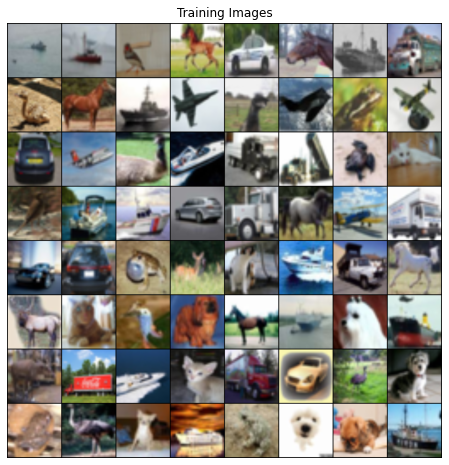

In [ ]:
# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# Custome weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Creating the generator (64x64)
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input Z goes into a convolution
        nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        # state size: (ngf*8) x 4 x 4
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        # state size: (ngf*4) x 8 x 8
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # state size: (ngf) x 16 x 16
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # state size:(ngf) x 32 x32
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # state size: (nc) x 64 x 64
    )
  def forward(self, input):
    return self.main(input)

In [ ]:
# (128x128)
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )
    def forward(self, input):
        return self.main(input)


In [ ]:
# Initialize the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init fuction to randomly initialize all weights to mean=0, stdev=0.2
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [ ]:
# Creating the discriminator (64x64)
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input is (nc) x 64 x 64
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size: (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size: (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # state size: (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )
  def forward(self, input):
    return self.main(input)

In [ ]:
# (128x128)
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
# Initializing the discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all the weights to mean=0, stdev=0.2
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progress of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for G and D
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training loop

# List to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print('Starting Training Loop...')
# For each epoch
for epoch in range(num_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(trainloader, 0):

    # ----Update D network----
    # Train with all-real batch
    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, device=device)
    # Forward pass real batch through D
    output = netD(real_cpu).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    # Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    # ---- Update G network----
    netG.zero_grad()
    label.fill_(real_label)
    # Since we just updated D, perform another forward pass of all-fake batch though D
    output = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()

    # Output training stats
    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      
    # Save losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(make_grid(fake, padding=2, normalize=True))

    iters += 1

Starting Training Loop...
[0/5][0/782]	Loss_D: 2.4123	Loss_G: 17.1283	D(x): 0.5372	D(G(z)): 0.6008 / 0.0000
[0/5][50/782]	Loss_D: 0.0006	Loss_G: 44.1904	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[0/5][100/782]	Loss_D: 0.0001	Loss_G: 44.1143	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][150/782]	Loss_D: 0.0007	Loss_G: 43.9732	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[0/5][200/782]	Loss_D: 0.0000	Loss_G: 43.3046	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][250/782]	Loss_D: 0.0000	Loss_G: 43.0952	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][300/782]	Loss_D: 0.0000	Loss_G: 42.9840	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][350/782]	Loss_D: 0.0002	Loss_G: 43.0104	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/5][400/782]	Loss_D: 0.0000	Loss_G: 42.8878	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][450/782]	Loss_D: 0.0000	Loss_G: 42.9806	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][500/782]	Loss_D: 0.0001	Loss_G: 42.4186	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][550/782]	Loss_D: 0.0000	Loss_G: 42.0261	D(x): 1

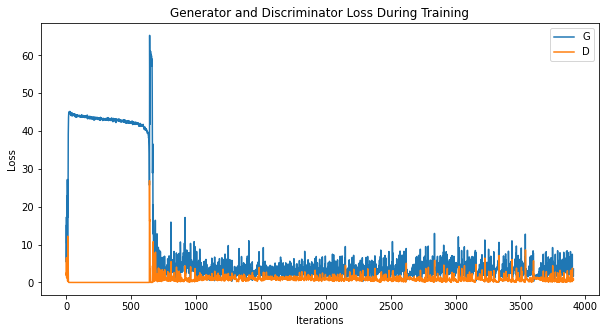

In [ ]:
# Plot D & G's losses versus training iterations
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label='D')
plt.xlabel("Iterations")
plt.ylabel('Loss')
plt.legend()
plt.show()

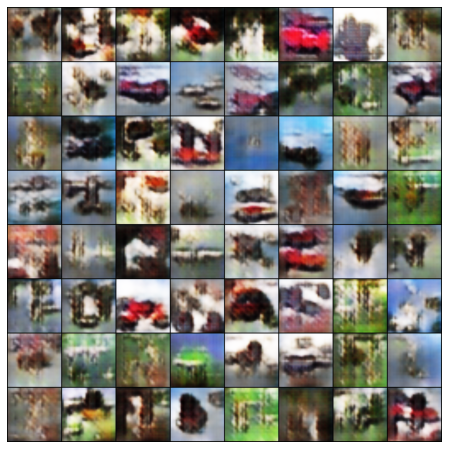

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

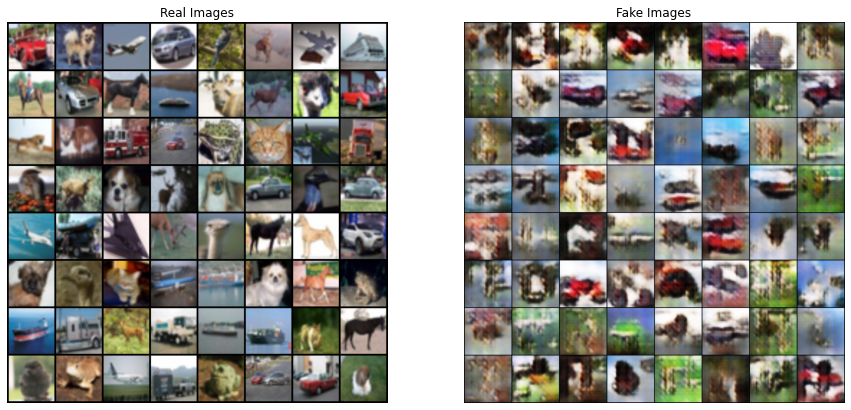

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(trainloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()